In [1]:
import os
os.environ['CLMM_MODELING_BACKEND'] = 'ct'
import sys
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# CLMM with ct be
import clmm
import clmm.theory as m
from clmm import Cosmology as clmm_cosmo

Loading:  ct


In [3]:
import cluster_toolkit as ct

In [4]:
# NumCosmo
try:
  import gi
  gi.require_version('NumCosmo', '1.0')
  gi.require_version('NumCosmoMath', '1.0')
except:
  pass

from gi.repository import GObject
from gi.repository import NumCosmo as Nc
from gi.repository import NumCosmoMath as Ncm

In [5]:
# Colossus
from colossus.cosmology import cosmology as col_cosmo
from colossus.halo import profile_nfw
from colossus.halo import profile_einasto
from colossus.halo import profile_hernquist
from colossus.halo import mass_so
from colossus.utils import constants

In [6]:
#CCL
import pyccl as ccl

# Comparison of NFW and Einasto for the various backends

In [7]:
# Colossus Cosmology
cosmo_col = col_cosmo.setCosmology('planck18'); # no massive neutrinos

Omega_c_col = cosmo_col.Om0 - cosmo_col.Ob0
Omega_b_col = cosmo_col.Ob0
h_col       = cosmo_col.H0 / 100.0
n_s_col     = cosmo_col.ns

# CCL Cosmology
cosmo_ccl = ccl.Cosmology(Omega_c=Omega_c_col, Omega_b=Omega_b_col, h=h_col, A_s=2.1e-9, n_s=n_s_col)

# NumCosmo Cosmology
Ncm.cfg_init ()
Ncm.cfg_set_log_handler (lambda msg: sys.stdout.write (msg) and sys.stdout.flush ())

cosmo = Nc.HICosmo.new_from_name (Nc.HICosmo, "NcHICosmoDEXcdm{'massnu-length':<0>}")
cosmo.omega_x2omega_k ()
cosmo.param_set_by_name ("H0",        cosmo_col.H0)
cosmo.param_set_by_name ("Omegak",    cosmo_col.Ok(0.0))
cosmo.param_set_by_name ("w",         cosmo_col.w0)
cosmo.param_set_by_name ("Omegab",    Omega_b_col)
cosmo.param_set_by_name ("Omegac",    Omega_c_col)
cosmo.param_set_by_name ("ENnu",      cosmo_col.Neff)
cosmo.param_set_by_name ("Tgamma0",   cosmo_col.Tcmb0)

# CLMM Cosmology: with CT backend, massive neutrinos not taken into account
cosmo_clmm = clmm_cosmo(H0 = cosmo_col.H0, Omega_dm0 = Omega_c_col, Omega_b0 = Omega_b_col, Omega_k0 = 0.0)
print(cosmo_col)

Cosmology "planck18" 
    flat = True, Om0 = 0.3111, Ode0 = 0.6888, Ob0 = 0.0490, H0 = 67.66, sigma8 = 0.8102, ns = 0.9665
    de_model = lambda, relspecies = True, Tcmb0 = 2.7255, Neff = 3.0460, powerlaw = False


In [8]:
Delta = 200
Delta_ccl = 'vir'
Mvir  = 1.0e15 # M_sun
cvir  = 5.0
z     = 0.2
a     = 1.0 / (1.0 + z)

# CCL
MDEF               = 'matter'
#mdef               = ccl.halos.MassDef (Delta_ccl, MDEF)
mdef               = ccl.halos.MassDef (Delta, MDEF)
conc               = ccl.halos.ConcentrationConstant(cvir)
mdef.concentration = conc
ccl_nfw_num            = ccl.halos.HaloProfileNFW (conc,
                                               truncated = False, 
                                               projected_analytic = False, 
                                               cumul2d_analytic = False)
ccl_nfw_ana            = ccl.halos.HaloProfileNFW (conc,
                                               truncated = False, 
                                               projected_analytic = True, 
                                               cumul2d_analytic = True)
#ccl_nfw.update_precision_fftlog (n_per_decade = 1200)
ccl_ein            = ccl.halos.HaloProfileEinasto (conc,
                                                   truncated = False)
ccl_her            = ccl.halos.HaloProfileHernquist (conc,
                                                     truncated = False)


alpha = ccl_ein._get_alpha (cosmo_ccl, Mvir, a, mdef)

# Colossus
# col_nfw = profile_nfw.NFWProfile (M = (Mvir * cosmo_col.h), c=cvir, z=z, mdef='vir')
# col_ein = profile_einasto.EinastoProfile (M = (Mvir * cosmo_col.h), c = cvir, z = z, mdef = 'vir', alpha = alpha)
# col_her = profile_hernquist.HernquistProfile (M = (Mvir * cosmo_col.h), c = cvir, z = z, mdef = 'vir')
col_nfw = profile_nfw.NFWProfile (M = (Mvir * cosmo_col.h), c=cvir, z=z, mdef='200m')
col_ein = profile_einasto.EinastoProfile (M = (Mvir * cosmo_col.h), c = cvir, z = z, mdef = '200m', alpha = alpha)
col_her = profile_hernquist.HernquistProfile (M = (Mvir * cosmo_col.h), c = cvir, z = z, mdef = '200m')


In [9]:
# NumCosmo
reltol = 1.0e-8
lnXi   = math.log (1.0e-4)
lnXf   = math.log (1.0e+4)
improve_prec = True

nc_nfw = Nc.HaloDensityProfileNFW.new (Nc.HaloDensityProfileMassDef.MEAN, Delta) 
#nc_nfw = Nc.HaloDensityProfileNFW.new (Nc.HaloDensityProfileMassDef.VIRIAL, Delta) 
#nc_nfw.param_set_by_name ('cDelta', cvir) 
#nc_nfw.param_set_by_name ('log10MDelta', math.log10(Mvir)) 

nc_nfw.props.cDelta = cvir
nc_nfw.props.log10MDelta = math.log10(Mvir)

if improve_prec:
    nc_nfw.set_reltol (reltol) 
    nc_nfw.set_lnXi (lnXi)
    nc_nfw.set_lnXf (lnXf)

nc_ein = Nc.HaloDensityProfileEinasto.new (Nc.HaloDensityProfileMassDef.MEAN, Delta)
#nc_ein = Nc.HaloDensityProfileEinasto.new (Nc.HaloDensityProfileMassDef.V, Delta)
# nc_ein.param_set_by_name ('cDelta', cvir) 
# nc_ein.param_set_by_name ('log10MDelta', math.log10(Mvir))
# nc_ein.param_set_by_name ('alpha', alpha)
nc_ein.props.cDelta = cvir
nc_ein.props.log10MDelta = math.log10(Mvir)
nc_ein.props.alpha = alpha

if improve_prec:
    nc_ein.set_reltol (reltol) 
    nc_ein.set_lnXi (lnXi)
    nc_ein.set_lnXf (lnXf)

nc_her = Nc.HaloDensityProfileHernquist.new (Nc.HaloDensityProfileMassDef.MEAN, Delta)
#nc_her = Nc.HaloDensityProfileHernquist.new (Nc.HaloDensityProfileMassDef.VIRIAL, Delta)
# nc_her.param_set_by_name ('cDelta', cvir) 
# nc_her.param_set_by_name ('log10MDelta', math.log10(Mvir))
nc_her.props.cDelta = cvir
nc_her.props.log10MDelta = math.log10(Mvir)

if improve_prec:
    nc_her.set_reltol (reltol) 
    nc_her.set_lnXi (lnXi)
    nc_her.set_lnXf (lnXf)

smd = Nc.WLSurfaceMassDensity.new (Nc.Distance.new (5.0))
smd.prepare (cosmo)

## Sigma

In [10]:
r     = 10**np.arange (0, +4, 0.02) * 1.0e-3 # Mpc - physical
rho_m = cosmo_col.rho_m (z) * (cosmo.h2 () * 1.0e9) # matter density units: M_sun / Mpc^3

# Colossus
col_Sigma_nfw = col_nfw.surfaceDensity (r * cosmo_col.h * 1.0e3) * (cosmo.h () * 1.0e6)
col_Sigma_ein = col_ein.surfaceDensity (r * cosmo_col.h * 1.0e3) * (cosmo.h () * 1.0e6)
col_Sigma_her = col_her.surfaceDensity (r * cosmo_col.h * 1.0e3) * (cosmo.h () * 1.0e6)

# NumCosmo
# Analytical
nc_Sigma_nfw_ana  = smd.sigma_array (nc_nfw, cosmo, r, 1.0, 1.0, z)
# Numerical 
Nc.halo_density_profile_nfw_class_set_ni (True)
nc_Sigma_nfw_num  = smd.sigma_array (nc_nfw, cosmo, r, 1.0, 1.0, z)
Nc.halo_density_profile_nfw_class_set_ni (False)
nc_Sigma_ein  = smd.sigma_array (nc_ein, cosmo, r, 1.0, 1.0, z)
nc_Sigma_her  = smd.sigma_array (nc_her, cosmo, r, 1.0, 1.0, z)

# CCL
ccl_Sigma_nfw_ana = ccl_nfw_ana.projected (cosmo_ccl, r / a, Mvir, a, mdef) / a**2
ccl_Sigma_nfw_num = ccl_nfw_num.projected (cosmo_ccl, r / a, Mvir, a, mdef) / a**2
ccl_Sigma_ein = ccl_ein.projected (cosmo_ccl, r / a, Mvir, a, mdef) / a**2
ccl_Sigma_her = ccl_her.projected (cosmo_ccl, r / a, Mvir, a, mdef) / a**2

# CT NFW through CLMM (analytical)
ct_Sigma_nfw = m.compute_surface_density(r, Mvir, cvir, z, cosmo=cosmo_clmm, delta_mdef=Delta,halo_profile_model= 'nfw')



## DeltaSigma

In [11]:
# Colossus
col_DeltaSigma_nfw = col_nfw.deltaSigma(r * cosmo_col.h * 1.0e3) * (cosmo.h () * 1.0e6)
col_DeltaSigma_ein = col_ein.deltaSigma (r * cosmo_col.h * 1.0e3) * (cosmo.h () * 1.0e6)
col_DeltaSigma_her = col_her.deltaSigma (r * cosmo_col.h * 1.0e3) * (cosmo.h () * 1.0e6)

# NumCosmo
# Analytical
nc_DeltaSigma_nfw_ana = np.array (smd.sigma_excess_array (nc_nfw, cosmo, r, 1.0, 1.0, z))
# Numerical
Nc.halo_density_profile_nfw_class_set_ni (True)
nc_DeltaSigma_nfw_num = np.array (smd.sigma_excess_array (nc_nfw, cosmo, r, 1.0, 1.0, z))
Nc.halo_density_profile_nfw_class_set_ni (False)
nc_DeltaSigma_ein  = np.array (smd.sigma_excess_array (nc_ein, cosmo, r, 1.0, 1.0, z))
nc_DeltaSigma_her  = np.array (smd.sigma_excess_array (nc_her, cosmo, r, 1.0, 1.0, z))

# CCL
ccl_BarSigma_nfw_ana = ccl_nfw_ana.cumul2d (cosmo_ccl, r / a, Mvir, a, mdef) / a**2
ccl_DeltaSigma_nfw_ana = ccl_BarSigma_nfw_ana - ccl_Sigma_nfw_ana
ccl_BarSigma_nfw_num = ccl_nfw_num.cumul2d (cosmo_ccl, r / a, Mvir, a, mdef) / a**2
ccl_DeltaSigma_nfw_num = ccl_BarSigma_nfw_num - ccl_Sigma_nfw_num
ccl_BarSigma_ein = ccl_ein.cumul2d (cosmo_ccl, r / a, Mvir, a, mdef) / a**2
ccl_DeltaSigma_ein = ccl_BarSigma_ein - ccl_Sigma_ein
ccl_BarSigma_her = ccl_her.cumul2d (cosmo_ccl, r / a, Mvir, a, mdef) / a**2
ccl_DeltaSigma_her = ccl_BarSigma_her - ccl_Sigma_her

# CT NFW through CLMM (analytical)
ct_DeltaSigma_nfw = m.compute_excess_surface_density(r, Mvir, cvir, z, cosmo=cosmo_clmm, 
                                  delta_mdef=Delta, 
                                  halo_profile_model='nfw')

## Special treatment for CT (numerical NFW and Einasto)

In [12]:
from clmm.constants import Constants as const

cor_factor = clmm.utils._patch_rho_crit_to_cd2018(2.77533742639e+11)
omega_m = cosmo_clmm.get_E2Omega_m(z)*cor_factor

rhocrit_mks = 3.*100.*100./(8.*np.pi*const.GNEWT.value)
rhocrit_cosmo = rhocrit_mks * 1000. * 1000. * const.PC_TO_METER.value * 1.e6 / const.SOLAR_MASS.value

r_for_sigma = np.logspace(np.log10(np.min(r)*0.7), np.log10(np.max(r)*1.3), len(r)*100)
r3d = np.logspace(np.log10(np.min(r)*0.5), np.log10(np.max(r)*1.5), len(r)*1000)

# CT NFW through CT (numerical)
rho_nfw = ct.density.rho_nfw_at_r(r3d*cosmo_clmm['h'], Mvir*cosmo_clmm['h'], cvir, omega_m, delta=Delta)
integrand_nfw = rho_nfw/(omega_m*rhocrit_cosmo) # xi_nfw + 1 (see CT documentation)

ct_Sigma_nfw_num = ct.deltasigma.Sigma_at_R(r*cosmo_clmm['h'], r3d*cosmo_clmm['h'], integrand_nfw, 
                                        Mvir*cosmo_clmm['h'], cvir, omega_m)*cosmo_clmm['h']*1.0e12 # Msun/Mpc2

# Redefine Sigma on finer grid for the numerical integration for DeltaSigma
tmp_nfw = ct.deltasigma.Sigma_at_R(r_for_sigma*cosmo_clmm['h'], r3d*cosmo_clmm['h'], integrand_nfw, 
                                        Mvir*cosmo_clmm['h'], cvir, omega_m)*cosmo_clmm['h']*1.0e12 # Msun/Mpc2
ct_DeltaSigma_nfw_num = ct.deltasigma.DeltaSigma_at_R(r*cosmo_clmm['h'], r_for_sigma*cosmo_clmm['h'], tmp_nfw, 
                                                  Mvir*cosmo_clmm['h'], cvir, omega_m)

# CT Einasto through CT


rho_einasto = ct.density.rho_einasto_at_r(r3d*cosmo_clmm['h'], Mvir*cosmo_clmm['h'], cvir, alpha, omega_m, delta=Delta)
integrand = rho_einasto/(omega_m*rhocrit_cosmo) # xi_einasto + 1 (see CT documentation)

ct_Sigma_ein = ct.deltasigma.Sigma_at_R(r*cosmo_clmm['h'], r3d*cosmo_clmm['h'], integrand, 
                                        Mvir*cosmo_clmm['h'], cvir, omega_m)*cosmo_clmm['h']*1.0e12 # Msun/Mpc2


# Redefine Sigma on finer grid for the numerical integration for DeltaSigma
tmp = ct.deltasigma.Sigma_at_R(r_for_sigma*cosmo_clmm['h'], r3d*cosmo_clmm['h'], integrand, 
                                        Mvir*cosmo_clmm['h'], cvir, omega_m)*cosmo_clmm['h']*1.0e12 # Msun/Mpc2
ct_DeltaSigma_ein = ct.deltasigma.DeltaSigma_at_R(r*cosmo_clmm['h'], r_for_sigma*cosmo_clmm['h'], tmp, 
                                                  Mvir*cosmo_clmm['h'], cvir, omega_m)

## NFW: compare NC (analytical and numerical), CCL (numerical), CT (analytical and numerical) to analytical CCL

<Figure size 432x288 with 0 Axes>

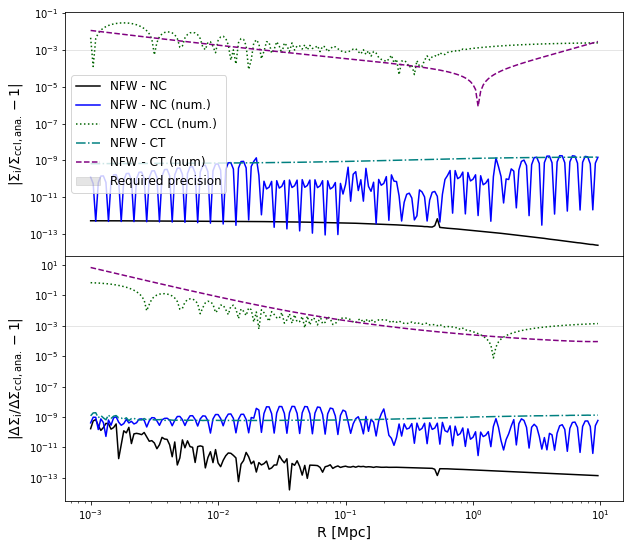

In [17]:
plt.figure()
fig, axs = plt.subplots (2, sharex=True, gridspec_kw={'hspace': 0},figsize=(10,9))

axs[0].plot (r, np.abs (nc_Sigma_nfw_ana / ccl_Sigma_nfw_ana - 1.0), '-', 
             label = "NFW - NC", linestyle='-', color='black')
axs[0].plot (r, np.abs (nc_Sigma_nfw_num / ccl_Sigma_nfw_ana - 1.0), '-', 
             label = "NFW - NC (num.)", linestyle='-', color='blue')
axs[0].plot (r, np.abs (ccl_Sigma_nfw_num / ccl_Sigma_nfw_ana - 1.0), '-', 
             label = "NFW - CCL (num.)", linestyle=':', color='darkgreen')
axs[0].plot (r, np.abs (ct_Sigma_nfw / ccl_Sigma_nfw_ana - 1.0), '-', 
             label = "NFW - CT", linestyle='-.', color='teal')
axs[0].plot (r, np.abs (ct_Sigma_nfw_num / ccl_Sigma_nfw_ana - 1.0), '-', 
             label = "NFW - CT (num)", linestyle='--', color='purple')

axs[1].plot (r, np.abs (nc_DeltaSigma_nfw_ana / ccl_DeltaSigma_nfw_ana - 1.0), '-', 
             label = "NFW - NC", linestyle='-', color='black')
axs[1].plot (r, np.abs (nc_DeltaSigma_nfw_num / ccl_DeltaSigma_nfw_ana - 1.0), '-', 
             label = "NFW - NC (num.)", linestyle='-', color='blue')
axs[1].plot (r, np.abs (ccl_DeltaSigma_nfw_num / ccl_DeltaSigma_nfw_ana - 1.0), '-', 
             label = "NFW - CCL (num.)", linestyle=':', color='darkgreen')
axs[1].plot (r, np.abs (ct_DeltaSigma_nfw / ccl_DeltaSigma_nfw_ana - 1.0), '-', 
             label = "NFW - CT", linestyle='-.', color='teal')
axs[1].plot (r, np.abs (ct_DeltaSigma_nfw_num / ccl_DeltaSigma_nfw_ana - 1.0), '-', 
             label = "NFW - CT (num)", linestyle='--', color='purple')

axs[0].set_xscale ('log')
axs[0].set_yscale ('log')
#axs[0].set_ylim([1.e-14,1.e0])
# axs[0].set_xlim([5.e-5,100])
axs[1].set_xlabel('R [Mpc]', fontsize=14)
axs[0].set_ylabel(r'$|\Sigma_{\mathrm{i}} / \Sigma_{\mathrm{ccl, ana.}} - 1|$', fontsize=14)
axs[1].set_xscale ('log')
axs[1].set_yscale ('log')
axs[1].set_ylabel(r'$|\Delta\Sigma_{\mathrm{i}} / \Delta\Sigma_{\mathrm{ccl, ana.}} - 1|$', fontsize=14)

axs[0].axhspan(9.9e-4,1.01e-3, alpha=0.2, color='grey', label='Required precision')
axs[1].axhspan(9.9e-4,1.01e-3, alpha=0.2, color='grey')
# axs[0].axhline(1.e-3, alpha=0.5, color='grey', label='Required precision')
# axs[1].axhline(1.e-3, alpha=0.5, color='grey')
axs[0].legend(fontsize=12, loc='best')

<Figure size 432x288 with 0 Axes>

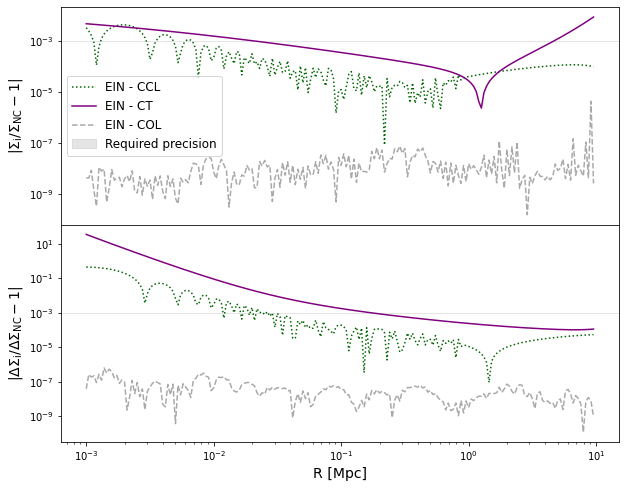

In [18]:
plt.figure()
fig, axs = plt.subplots (2, sharex=True, gridspec_kw={'hspace': 0},figsize=(10,8))

axs[0].plot (r, np.abs (ccl_Sigma_ein / nc_Sigma_ein - 1.0), '-', 
             label = "EIN - CCL", linestyle=':', color='darkgreen')
axs[0].plot (r, np.abs (ct_Sigma_ein / nc_Sigma_ein - 1.0), '-', 
             label = "EIN - CT", linestyle='-', color='purple')
axs[0].plot (r, np.abs (col_Sigma_ein / nc_Sigma_ein - 1.0), '-', 
             label = "EIN - COL", linestyle='--', color='darkgrey')
axs[1].plot (r, np.abs (ccl_DeltaSigma_ein / nc_DeltaSigma_ein - 1.0), '-', 
             label = "EIN - CCL", linestyle=':', color='darkgreen')
axs[1].plot (r, np.abs (ct_DeltaSigma_ein / nc_DeltaSigma_ein - 1.0), '-', 
             label = "EIN - CT", linestyle='-', color='purple')
axs[1].plot (r, np.abs (col_DeltaSigma_ein / nc_DeltaSigma_ein - 1.0), '-', 
             label = "EIN - COL", linestyle='--', color='darkgrey')

axs[0].set_xscale ('log')
axs[0].set_yscale ('log')
axs[1].set_xlabel('R [Mpc]', fontsize=14)
axs[0].set_ylabel(r'$|\Sigma_{\mathrm{i}} / \Sigma_{\mathrm{NC}} - 1|$', fontsize=14)
axs[1].set_xscale ('log')
axs[1].set_yscale ('log')
axs[1].set_ylabel(r'$|\Delta\Sigma_{\mathrm{i}} / \Delta\Sigma_{\mathrm{NC}} - 1|$', fontsize=14)
axs[0].axhspan(9.9e-4,1.01e-3, alpha=0.2, color='grey', label='Required precision')
axs[1].axhspan(9.9e-4,1.01e-3, alpha=0.2, color='grey')
axs[0].legend(fontsize=12)



# Compare all to Colossus

<Figure size 432x288 with 0 Axes>

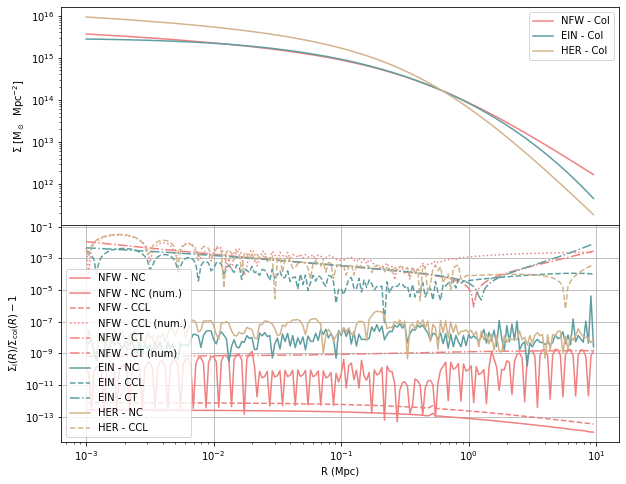

In [19]:
plt.figure()
fig, axs = plt.subplots (2, sharex=True, gridspec_kw={'hspace': 0}, figsize=(10,8))

axs[0].set_xscale ('log')
axs[0].set_yscale ('log')
axs[1].set_yscale ('log')
axs[1].set_xlabel('R (Mpc)')
axs[0].set_ylabel(r'$\Sigma$ [M$_\odot$  Mpc$^{-2}$]')
axs[1].set_ylabel(r'$\Sigma_{\mathrm{i}} (R) / \Sigma_{\mathrm{col}} (R) - 1$')
axs[0].plot (r, col_Sigma_nfw, '-', label = 'NFW - Col', color = 'lightcoral')
# axs[0].plot (r, nc_Sigma_nfw,  '-', label = 'NFW - Nc', color = 'lightcoral', linestyle=':')
# axs[0].plot (r, ccl_Sigma_nfw_ana, '-', label = 'NFWana - CCL', color = 'lightcoral', linestyle='-.')
# axs[0].plot (r, ccl_Sigma_nfw_num, '-', label = 'NFWnum - CCL', color = 'lightcoral', linestyle='--')
# axs[0].plot (r, ct_Sigma_nfw, '-', label = 'NFW - CT', color = 'lightcoral', linestyle='--')
axs[0].plot (r, col_Sigma_ein, '-', label = 'EIN - Col', color = 'cadetblue')
# axs[0].plot (r, nc_Sigma_ein,  '-', label = 'EIN - Nc', color = 'cadetblue', linestyle=':')
# axs[0].plot (r, ccl_Sigma_ein, '-', label = 'EIN - CCL', color = 'cadetblue', linestyle='--')
axs[0].plot (r, col_Sigma_her, '-', label = 'HER - Col', color = 'tan')
# axs[0].plot (r, nc_Sigma_her,  '-', label = 'HER - Nc', color = 'tan', linestyle=':')
# axs[0].plot (r, ccl_Sigma_her, '-', label = 'HER - CCL', color = 'tan', linestyle='--')

axs[1].plot (r, np.abs (nc_Sigma_nfw_ana / col_Sigma_nfw - 1.0), '-', label = "NFW - NC", linestyle='-', color='lightcoral')
axs[1].plot (r, np.abs (nc_Sigma_nfw_num / col_Sigma_nfw - 1.0), '-', label = "NFW - NC (num.)", linestyle='-', color='lightcoral')
axs[1].plot (r, np.abs (ccl_Sigma_nfw_ana / col_Sigma_nfw - 1.0), '-', label = "NFW - CCL", linestyle='--', color='lightcoral')
axs[1].plot (r, np.abs (ccl_Sigma_nfw_num / col_Sigma_nfw - 1.0), '-', label = "NFW - CCL (num.)", linestyle=':', color='lightcoral')
axs[1].plot (r, np.abs (ct_Sigma_nfw / col_Sigma_nfw - 1.0), '-', label = "NFW - CT", linestyle='-.', color='lightcoral')
axs[1].plot (r, np.abs (ct_Sigma_nfw_num / col_Sigma_nfw - 1.0), '-', label = "NFW - CT (num)", linestyle='-.', color='lightcoral')
axs[1].plot (r, np.abs (nc_Sigma_ein / col_Sigma_ein - 1.0), '-', label = "EIN - NC", color='cadetblue', linestyle='-')
axs[1].plot (r, np.abs (ccl_Sigma_ein / col_Sigma_ein - 1.0), '-', label = "EIN - CCL", color='cadetblue', linestyle='--')
axs[1].plot (r, np.abs (ct_Sigma_ein / col_Sigma_ein - 1.0), '-', label = "EIN - CT", color='cadetblue', linestyle='-.')
axs[1].plot (r, np.abs (nc_Sigma_her / col_Sigma_her - 1.0), '-', label = "HER - NC", color='tan', linestyle='-')
axs[1].plot (r, np.abs (ccl_Sigma_her / col_Sigma_her - 1.0), '-', label = "HER - CCL", color='tan', linestyle='--')

axs[0].legend(loc='best')
axs[1].legend(loc='best')
axs[1].grid()
plt.show ()
#fig.savefig('Sigma_precision.pdf')

<Figure size 432x288 with 0 Axes>

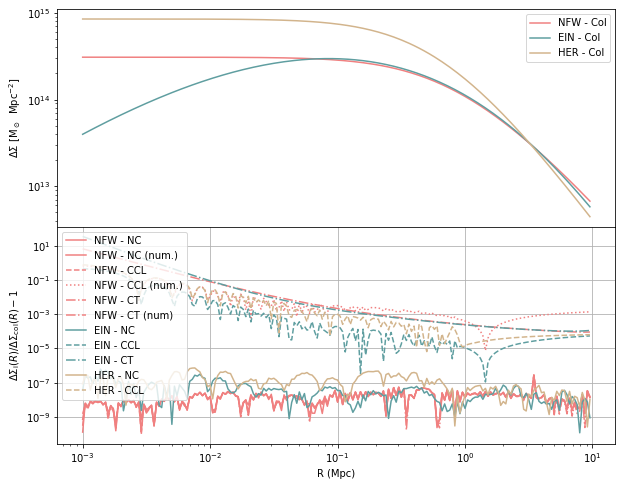

In [20]:
plt.figure()
fig, axs = plt.subplots (2, sharex=True, gridspec_kw={'hspace': 0}, figsize=(10,8))

axs[0].set_xscale ('log')
axs[0].set_yscale ('log')
axs[1].set_yscale ('log')
axs[1].set_xlabel('R (Mpc)')
axs[0].set_ylabel(r'$\Delta\Sigma$ [M$_\odot$  Mpc$^{-2}$]')
axs[1].set_ylabel(r'$\Delta\Sigma_{\mathrm{i}} (R) / \Delta\Sigma_{\mathrm{col}} (R) - 1$')
axs[0].plot (r, col_DeltaSigma_nfw, '-', label = 'NFW - Col', color = 'lightcoral')
# axs[0].plot (r, nc_DeltaSigma_nfw,  '-', label = 'NFW - Nc', color = 'lightcoral', linestyle=':')
# axs[0].plot (r, ccl_DeltaSigma_nfw_ana, '-', label = 'NFWana - CCL', color = 'lightcoral', linestyle='-.')
#axs[0].plot (r, ccl_DeltaSigma_nfw_num, '-', label = 'NFWnum - CCL', color = 'lightcoral', linestyle='--')
# axs[0].plot (r, ct_DeltaSigma_nfw, '-', label = 'NFW - CT', color = 'lightcoral')
axs[0].plot (r, col_DeltaSigma_ein, '-', label = 'EIN - Col', color = 'cadetblue')
# axs[0].plot (r, nc_DeltaSigma_ein,  '-', label = 'EIN - Nc', color = 'cadetblue', linestyle=':')
# axs[0].plot (r, ccl_DeltaSigma_ein, '-', label = 'EIN - CCL', color = 'cadetblue', linestyle='--')
axs[0].plot (r, col_DeltaSigma_her, '-', label = 'HER - Col', color = 'tan')
# axs[0].plot (r, nc_DeltaSigma_her,  '-', label = 'HER - Nc', color = 'tan', linestyle=':')
# axs[0].plot (r, ccl_DeltaSigma_her, '-', label = 'HER - CCL', color = 'tan', linestyle='--')
axs[1].plot (r, np.abs (nc_DeltaSigma_nfw_ana / col_DeltaSigma_nfw - 1.0), '-', label = "NFW - NC", linestyle='-', color='lightcoral')
axs[1].plot (r, np.abs (nc_DeltaSigma_nfw_num / col_DeltaSigma_nfw - 1.0), '-', label = "NFW - NC (num.)", linestyle='-', color='lightcoral')
axs[1].plot (r, np.abs (ccl_DeltaSigma_nfw_ana / col_DeltaSigma_nfw - 1.0), '-', label = "NFW - CCL", linestyle='--', color='lightcoral')
axs[1].plot (r, np.abs (ccl_DeltaSigma_nfw_num / col_DeltaSigma_nfw - 1.0), '-', label = "NFW - CCL (num.)", linestyle=':', color='lightcoral')
axs[1].plot (r, np.abs (ct_DeltaSigma_nfw / col_DeltaSigma_nfw - 1.0), '-', label = "NFW - CT", linestyle='-.', color='lightcoral')
axs[1].plot (r, np.abs (ct_DeltaSigma_nfw_num / col_DeltaSigma_nfw - 1.0), '-', label = "NFW - CT (num)", linestyle='-.', color='lightcoral')
axs[1].plot (r, np.abs (nc_DeltaSigma_ein / col_DeltaSigma_ein - 1.0), '-', label = "EIN - NC", linestyle='-', color='cadetblue')
axs[1].plot (r, np.abs (ccl_DeltaSigma_ein / col_DeltaSigma_ein - 1.0), '-', label = "EIN - CCL", linestyle='--', color='cadetblue')
axs[1].plot (r, np.abs (ct_DeltaSigma_ein / col_DeltaSigma_ein - 1.0), '-', label = "EIN - CT", linestyle='-.', color='cadetblue')
axs[1].plot (r, np.abs (nc_DeltaSigma_her / col_DeltaSigma_her - 1.0), '-', label = "HER - NC", linestyle='-', color='tan')
axs[1].plot (r, np.abs (ccl_DeltaSigma_her / col_DeltaSigma_her - 1.0), '-', label = "HER - CCL", linestyle='--', color='tan')

#axs[1].set_ylim([1.e-9,1.e1])
axs[0].legend(loc='best')
axs[1].legend(loc='best')
axs[1].grid()
plt.show ()
#fig.savefig('DeltaSigma_precision.pdf')